In [66]:
import pickle
from __future__ import division

# Python 2 & 3 Compatibility
from __future__ import print_function, division
from sklearn import linear_model,ensemble, tree, model_selection, datasets

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
from sklearn import preprocessing as pp

import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import scipy.stats as stats


In [67]:
# Get the dataset from the pickle

with open("kickstarter_data_pickle.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)
df = df.reset_index(drop=True)

In [68]:
# create the response variable (y) which will be the % relationship to 'on-track' toward the campaign goal.  i.e. a campaign that is 40% through its allowed time should be 40% of the way toward its $ goal.  If the campaign is at 30% of its $ goal then it is at 30/40 = 
df['total_days'] = df['days_remaining']
df.loc[df['total_days'] > 29, 'total_days'] = 60
df.loc[df['total_days'] < 30, 'total_days'] = 30
# technically this is an assumption.  It is nearly universal to run a campaign for 30 days, (the default) or 60 days (the max) but I was unable to scrape the campaign start date so I cannot be sure of the exact total length.  There will definitely be some error introduced here.  

df['percent_complete_time'] = (df['total_days'] - df['days_remaining'])/df['total_days'] # How far through the campaign are they (a score of 1 means they're done).
df['current_target_funds'] = df['total_goal']*df['percent_complete_time']
df['y'] = df['raised_so_far']/df['current_target_funds'] # the percent of the current target funds which have been raised.  



In [69]:
# change a couple of data types and scale a few things
df['updates_scaled'] = df['updates_total']*df['total_days']/(df['total_days'] - df['days_remaining']) # we scale the updates based on the assumption that campaigns will continue posting as often as they have done.  
df['backers_scaled'] = df['backers_count']*df['total_days']/(df['total_days'] - df['days_remaining']) # we scale the backers based on the assumption that campaigns will accruing backers as often as they have done.  
df.all_or_nothing.unique() #shows that ALL camnpaigns were 'all or nothing' type so we will not be including that variable.  

df[['total_goal','backers_count','days_remaining','number_images','contains_video','tier_count','title_length','all_or_nothing','total_text','total_days']] = df[['total_goal','backers_count','days_remaining','number_images','contains_video','tier_count','title_length','all_or_nothing','total_text','total_days']].astype(int)
df[['updates_scaled']] = df[['updates_scaled']].astype(float)
df[['backers_scaled']] = df[['backers_scaled']].astype(float)

df['total_days_binary'] = df['total_days']
df.loc[df['total_days_binary'] == 30, 'total_days_binary'] = 1
df.loc[df['total_days_binary'] == 60, 'total_days_binary'] = 0


In [70]:
#here's the matrix of variables we care about here: 

dfx = df[['total_goal','backers_scaled','number_images','contains_video','tier_count','updates_scaled','title_length','total_text','total_days','y']].copy()
dfx = dfx[dfx.y < 5]

# We also can't take the log of 0 for those campaigns that have raised nothing so far 
#dfx['y'] = dfx['y']+.001   # so we could simply give them 1 cent
dfx = dfx[dfx.y != 0] # or we could remove them from the dataset.  

dfx.corr()
#dfx.info()


,total_goal,backers_scaled,number_images,contains_video,tier_count,updates_scaled,title_length,total_text,total_days
total_goal,1.000000,0.262742,0.097397,0.063295,0.035208,0.001725,-0.007649,0.153234,0.050043
backers_scaled,0.262742,1.000000,0.263059,0.110473,0.137613,0.228440,0.005444,0.222911,-0.053239
number_images,0.097397,0.263059,1.000000,0.173836,0.297501,0.209192,0.130526,0.445501,-0.030529
contains_video,0.063295,0.110473,0.173836,1.000000,0.150150,0.129097,0.047185,0.193876,-0.017285
tier_count,0.035208,0.137613,0.297501,0.150150,1.000000,0.180116,0.064274,0.560014,-0.052054
updates_scaled,0.001725,0.228440,0.209192,0.129097,0.180116,1.000000,0.070169,0.223417,-0.070860
title_length,-0.007649,0.005444,0.130526,0.047185,0.064274,0.070169,1.000000,0.153803,-0.006166
total_text,0.153234,0.222911,0.445501,0.193876,0.560014,0.223417,0.153803,1.000000,-0.015411
total_days,0.050043,-0.053239,-0.030529,-0.017285,-0.052054,-0.070860,-0.006166,-0.015411,1.000000


# Create the feature matrix (X) and target vector (y)


In [71]:
dfx['images_X_text'] = df['number_images']*df['total_text']
dfx['tiers_X_text'] = df['tier_count']*df['total_text']


X = dfx.drop(['y'], axis=1) #That would be all the X_i but we have some colinearity that's so bad we're encountering an ill_defined model.  
#X = dfx['days_remaining']
X = sm.add_constant(X)
y = list(dfx.y)

# Split the dataset into parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Add in a polynomial term for each feature in the dataset 

In [72]:
df1 = df[['total_goal','backers_scaled','number_images','contains_video','tier_count','updates_scaled','title_length','total_text','total_days','y']].copy()
df1 = df1[df1.y < 5]

df1 = df1[df1.y != 0] # or we could remove them from the dataset.  

In [73]:


X = dfx.drop(['y'], axis=1) #That would be all the X_i but we have some colinearity that's so bad we're encountering an ill_defined model.  
#X = dfx['days_remaining']
y = list(dfx.y)

poly = pp.PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

# Split the dataset into parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Apply Lasso

In [74]:
# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [10**(-3), 10**(-2), 10**(-1), 1, 10, 100]},
                    {'normalize': [True, False]}]

array = np.arange(0,1,.01)
tuned_parameters1 = [{'alpha': list(array)}, {'normalize': [True, False]}]

clf = GridSearchCV(linear_model.Lasso(), tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']


#Now with  best_params as alpha, 
alpha = .23 # for now

lasso = linear_model.Lasso(alpha)
#Note, it's right in there we'd choose ...Lasso(alpha = .1)

cv_results = cross_validate(lasso, X, y, return_train_score=False)
sorted(cv_results.keys())                         
#['fit_time', 'score_time', 'test_score']
cv_results['test_score']    
#array([ 0.33...,  0.08...,  0.03...])


scores = cross_validate(lasso, X, y, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

lasso = Lasso(alpha, normalize = False)
lasso.fit(X_train,np.log(y_train))

# View each feature and its coefficient
for feature, coef in zip(X_train.columns, lasso.coef_):
    print(feature, coef)

Best parameters set found on development set:

{'alpha': 0.1}

Grid scores on development set:

total_goal -1.3412445804497343e-05
backers_scaled 0.0011003158967442931
number_images 0.03488900568951334
contains_video 0.0
tier_count 0.05882637471144313
updates_scaled 0.05488927579779765
title_length 0.00044462004025739985
total_text 4.016629203001983e-05
total_days -0.016353968369974145
images_X_text -1.6642479719798157e-06
tiers_X_text -1.5477567198045825e-06


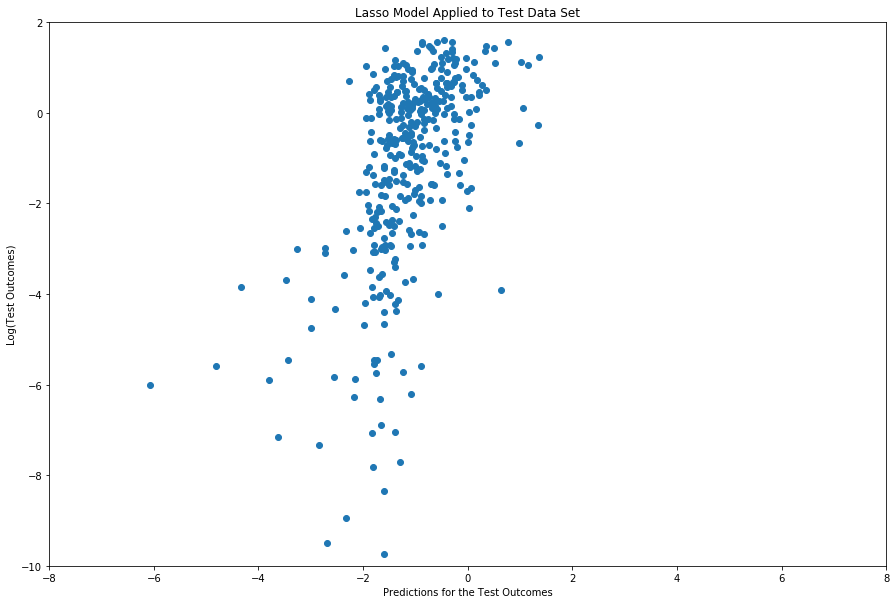

In [75]:
plt.figure(figsize=(15,10));
predictions2 = lasso.predict(X_test)
plt.scatter(predictions2,np.log(y_test))
plt.ylabel("Log(Test Outcomes)")
plt.xlabel('Predictions for the Test Outcomes')
plt.title('Lasso Model Applied to Test Data Set')
plt.axis([-8, 8, -10, 2]);

In [76]:
# How good is our model on the test set?

# Root Mean Square Error
print('Root Mean Square Error: ')
print(np.sqrt(np.mean((predictions2 - y_test)**2)))
print()
# Mean Absolute Deviation
print('Mean Absolute Deviation')
print((np.mean(np.abs(predictions2 - y_test))))
print()

# Adjusted by sqrt for our particular model
print('Adjusted RMSE')
print(np.log(np.sqrt(np.mean((predictions2 - y_test)**2))))
# Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. 
# As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, 
# and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate 
# better fit.

Root Mean Square Error: 
2.6052176831661247

Mean Absolute Deviation
2.2223728482220735

Adjusted RMSE
0.9575162353095288
